In [45]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

def load_data(base_path):
    files = {
        "contribution": ("Zusatzbeitrag_je Kasse je Quartal.xlsx", "Sheet1"),
        "morbidity": ("Morbidity_Region.xlsx", "data"),
        "market": ("Marktanteile je Kasse.xlsx", "data")
    }

    dataframes = {}
    for name, (filename, sheetname) in files.items():
        full_path = os.path.join(base_path, filename)
        df = pd.read_excel(full_path, sheet_name=sheetname)
        dataframes[name] = df
    for df in dataframes.values():
        df["Krankenkasse"] = df["Krankenkasse"].str.strip().str.lower()
        df["Jahr"] = df["Jahr"].astype(int)
    merged = pd.merge(
       dataframes["contribution"],
        dataframes["morbidity"][["Krankenkasse", "Jahr", "Risikofaktor"]],
        on=["Krankenkasse", "Jahr"],
        how="left"
    )
    merged = pd.merge(
        merged,
        dataframes["market"][["Krankenkasse", "Jahr", "Marktanteil Mitglieder", "Marktanteil Versicherte"]],
        on=["Krankenkasse", "Jahr"],
        how="left"
    )
    return merged


In [5]:
def preprocess(df):
    # Sort values
    df = df.sort_values(by=['Krankenkasse', 'Jahr', 'Quartal'])

    # Previous values (lags)
    df['Zusatzbeitrag_prev'] = df.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
    df['Mitglieder_prev'] = df.groupby('Krankenkasse')['Mitglieder'].shift(1)
    df['churn_abs'] = df['Mitglieder_prev'] - df['Mitglieder']

    # Relative churn (%)
    df['churn_rel'] = (df['churn_abs'] / df['Mitglieder_prev']) * 100

    # Rate change
    df['rate_change'] = df['Zusatzbeitrag'] - df['Zusatzbeitrag_prev']

    # Lagged churn
    df['churn_rel_prev'] = df.groupby('Krankenkasse')['churn_rel'].shift(1)

    # Time features
    df['year'] = df['Jahr']
    df['quarter'] = df['Quartal']
    df = pd.get_dummies(df, columns=['quarter'], prefix='Q')

    # Competitor statistics
    df['avg_competitor_rate_excl_self'] = (
        (df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform('sum') - df['Zusatzbeitrag']) /
        (df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform('count') - 1)
    )
    df['min_competitor_rate'] = df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform('min')
    df['max_competitor_rate'] = df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform('max')

    # Rolling stats
    df['rolling_churn_mean'] = df.groupby('Krankenkasse')['churn_rel'].transform(lambda x: x.rolling(4).mean())
    df['rolling_rate_std'] = df.groupby('Krankenkasse')['Zusatzbeitrag'].transform(lambda x: x.rolling(4).std())

    # Drop early rows with NaNs from shifting/rolling
    df = df.dropna(subset=['Zusatzbeitrag_prev', 'Mitglieder_prev', 'churn_rel', 'avg_competitor_rate_excl_self'])

    return df

In [46]:
def train_model(train, features, target):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train[features], train[target])
    return model

def evaluate_model(model, test, features, target):
    preds = model.predict(test[features])
    test['predicted_churn'] = preds
    print("MAE:", mean_absolute_error(test[target], test['predicted_churn']))
    print("MSE:", mean_squared_error(test[target], test['predicted_churn']))
    print("R2:", r2_score(test[target], test['predicted_churn']))   
    return test

In [47]:
# Load and preprocess
df = load_data('data/')
df = preprocess(df)
# Feature and target selection
target = 'churn_rel'
features = [
    'Zusatzbeitrag', 'Zusatzbeitrag_prev', 'rate_change',
    'avg_competitor_rate_excl_self', 'min_competitor_rate', 'max_competitor_rate',
    'Marktanteil Mitglieder',
    'churn_rel_prev', 'rolling_churn_mean', 'rolling_rate_std',
    'year'
] + [col for col in df.columns if col.startswith('Q_')]
df.dropna(subset=['Zusatzbeitrag', 'Marktanteil Mitglieder','Risikofaktor'] + [target], inplace=True)
# Time-based split
train = df[df['Jahr'] < 2023]
test = df[df['Jahr'] >= 2023]
# Train and evaluate
model = train_model(train, features, target)
test_results = evaluate_model(model, test, features, target)
# Save predictions

MAE: 0.5154454017826232
MSE: 1.551817357484754
R2: 0.36371354438071535


/tmp/ipykernel_9765/4077877507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_churn'] = preds


In [67]:
merged = df.copy()
def quarter_to_date(row):
    quarter_end_month = {1: 3, 2: 6, 3: 9, 4: 12}
    month = quarter_end_month[row['Quartal']]
    return pd.to_datetime(f"{int(row['Jahr'])}-{month}-01") + pd.offsets.MonthEnd(0)

merged['date'] = merged.apply(quarter_to_date, axis=1)
merged = merged.set_index('date')
merged = merged.sort_index()

# --- Step 2: Get top 10 funds by Mitglieder ---
latest_quarter = merged.reset_index().groupby('Krankenkasse')['date'].max()
latest_data = merged.reset_index().merge(latest_quarter, on=['Krankenkasse', 'date'])
top_funds = latest_data.sort_values('Mitglieder', ascending=False)['Krankenkasse'].head(10).tolist()


DatetimeIndex(['2016-03-31', '2016-03-31', '2016-03-31', '2016-03-31',
               '2016-03-31', '2016-03-31', '2016-03-31', '2016-03-31',
               '2016-03-31', '2016-03-31',
               ...
               '2025-03-31', '2025-03-31', '2025-03-31', '2025-03-31',
               '2025-03-31', '2025-03-31', '2025-03-31', '2025-03-31',
               '2025-03-31', '2025-03-31'],
              dtype='datetime64[ns]', name='date', length=3586, freq=None)

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
def load_and_prepare_data() -> pd.DataFrame:
    df = pd.read_csv('merged_data.csv')  # Replace with your path
    df = df.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
    df['date'] = pd.to_datetime(df['Jahr'].astype(str) + 'Q' + df['Quartal'].astype(str))
    df.set_index('date', inplace=True)
    df = filter_funds_with_2025_q1(df)
    df.dropna(subset=['Zusatzbeitrag', 'Mitglieder'], inplace=True)
    df['competitor_contrib'] = compute_competitor_contrib_knn(df)
    print("competitor_contrib computed", df['competitor_contrib'])
    df = add_additional_features(df)
    return df

def filter_funds_with_2025_q1(df: pd.DataFrame) -> pd.DataFrame:
    required_quarter = pd.to_datetime("2025Q1")
    valid_funds = df[df.index == required_quarter]['Krankenkasse'].unique()
    return df[df['Krankenkasse'].isin(valid_funds)].copy()

def compute_intelligent_competitor_contrib(df: pd.DataFrame) -> pd.Series:
    def calc_competitor_avg(row, quarter_df):
        filtered = quarter_df[
            (quarter_df['Krankenkasse'] != row['Krankenkasse']) &
            (quarter_df['Zusatzbeitrag'].between(row['Zusatzbeitrag'] - 0.5, row['Zusatzbeitrag'] + 0.5))
        ]
        return filtered['Zusatzbeitrag'].mean() if not filtered.empty else np.nan

    contrib_series = pd.Series(index=df.index, dtype='float64')
    for (jahr, quartal), group in df.groupby(['Jahr', 'Quartal']):
        quarter_df = group.copy()
        contrib_series.loc[group.index] = quarter_df.apply(
            lambda row: calc_competitor_avg(row, quarter_df), axis=1
        )
    return contrib_series
def compute_competitor_contrib_knn(df: pd.DataFrame) -> pd.Series:
    df = df.copy()
    contrib_values = {}

    df_reset = df.reset_index()  # Keep original index in a column
    df_reset['_orig_index'] = df.index  # Save original index before drop=True

    for (jahr, quartal), group in df_reset.groupby(['Jahr', 'Quartal']):
        group = group.reset_index(drop=True)  # This index is temporary
        features = group[['Mitglieder', 'Zusatzbeitrag', 'Jahr', 'Quartal']].to_numpy()

        # Compute pairwise Euclidean distances
        dists = pairwise_distances(features, metric='euclidean')

        for i, row in group.iterrows():
            dist_to_others = dists[i].copy()
            dist_to_others[i] = np.inf  # ignore self

            top_k_indices = np.argsort(dist_to_others)[:10]
            mean_contrib = group.loc[top_k_indices, 'Zusatzbeitrag'].mean()

            orig_idx = row['_orig_index']
            contrib_values[orig_idx] = mean_contrib

            if row['Krankenkasse'] == 'techniker-krankenkasse (tk)':
                print(top_k_indices, row['Mitglieder'], row['Zusatzbeitrag'], mean_contrib)

    # Return as Series with proper index matching df
    contrib_series = pd.Series(contrib_values, index=df.index)
    
    # Fill any missing values with overall mean or some fallback
    contrib_series = contrib_series.fillna(df['Zusatzbeitrag'].mean())

    return contrib_series

def add_additional_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Zusatzbeitrag_prev'] = df.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
    df['Zusatz_diff'] = df['Zusatzbeitrag'] - df['competitor_contrib']
    df['is_start_of_year'] = (df['Quartal'] == 1).astype(int)
    return df

df = load_and_prepare_data()

/tmp/ipykernel_14222/915301956.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['Jahr'].astype(str) + 'Q' + df['Quartal'].astype(str))


[61 13  1  0 70  7  9  6  4  5] 5965956 0.0 0.0
[61 13  1  0 70  7  9  6  4  5] 6048940 0.0 0.0
[61 13  1  0 70  7  9  6  4  5] 6133353 0.0 0.0
[61 13  1  0 70  7  9  6  4 75] 6248736 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6319407 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6419030 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6511810 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6639532 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6721642 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4 75] 6809575 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4 75] 6867467 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4 75] 6976235 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4  5] 7044467 1.0 1.06
[13 61  1  0 70  7  9  6  4  5] 7156419 1.0 1.06
[13 61  1  0 70  7  9  6  4  5] 7208631 1.0 1.06
[13 61  1  0 70  7  9  6  4  5] 7296182 1.0 1.06
[13 61  1  0  7 70  9  6  4  5] 7342157 1.0 1.09
[13 61  1  0  7 70  9  6  4  5] 7405340 1.0 1.09
[13 61  1  0  7 70  9  6  4  5] 7450153 1.0 1.09
[13 61  1  0  7 70  9

Text(0, 0.5, 'Zusatzbeitrag')

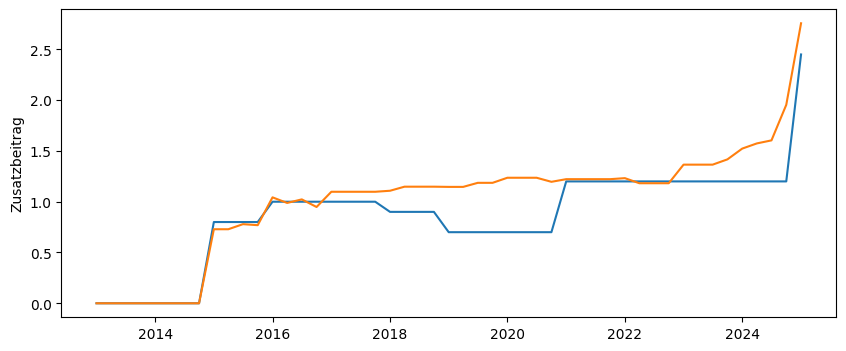

In [19]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df[df['Krankenkasse'] == 'techniker-krankenkasse (tk)']['Zusatzbeitrag'], label='TK Zusatzbeitrag')
ax.plot( df[df['Krankenkasse'] == 'techniker-krankenkasse (tk)']['competitor_contrib'], label='Competitor Avg')
ax.set_ylabel('Zusatzbeitrag')